In [1]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from lenstools import ConvergenceMap
from astropy import units as u

In [2]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
config = load_config(config_file)
setup_logging()
zs =2.0

In [4]:
patch_size = config["patch_size"]
nbin = config["nbin"]
lmin, lmax = config["lmin"], config["lmax"]
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1, endpoint=True)
ell = (l_edges[1:] + l_edges[:-1]) / 2

In [5]:

sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[1]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[1]

In [6]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

In [7]:
# exclude index 130, 132, 134
sample_patch_tiled = np.delete(sample_patch_tiled, [130, 132, 134], axis=0)
sample_patch_bigbox = np.delete(sample_patch_bigbox, [130, 132, 134], axis=0)

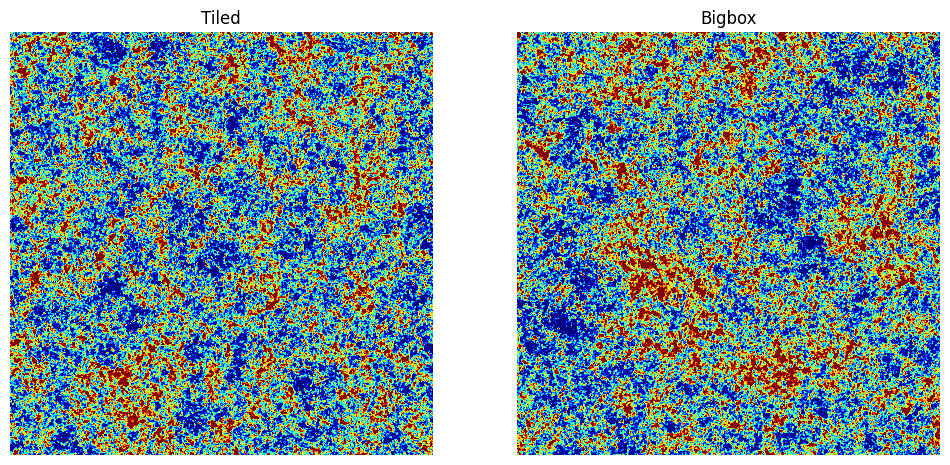

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sample_patch_tiled[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[0].set_title("Tiled")

ax[1].imshow(sample_patch_bigbox[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[1].set_title("Bigbox")

for a in ax:
    a.axis("off")

plt.show()

In [9]:
def normalize_cl(cl):
    return (cl - np.mean(cl, axis=0)) / np.std(cl, axis=0)

In [10]:
cl_tiled = []
for patch in sample_patch_tiled:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg)
    _, cl = conv_map.powerSpectrum(l_edges)
    cl_tiled.append(cl)

cl_tiled = np.array(cl_tiled)

cl_bigbox = []
for patch in sample_patch_bigbox:
    conv_map = ConvergenceMap(patch, angle=patch_size * u.deg)
    _, cl = conv_map.powerSpectrum(l_edges)
    cl_bigbox.append(cl)

cl_bigbox = np.array(cl_bigbox)

KeyboardInterrupt: 

In [ ]:
cl_tiled_reduced = cl_tiled * ell * (ell + 1) / (2 * np.pi)
cl_bigbox_reduced = cl_bigbox * ell * (ell + 1) / (2 * np.pi)

In [ ]:
cl_tiled_norm = normalize_cl(cl_tiled_reduced)
cl_bigbox_norm = normalize_cl(cl_bigbox_reduced)

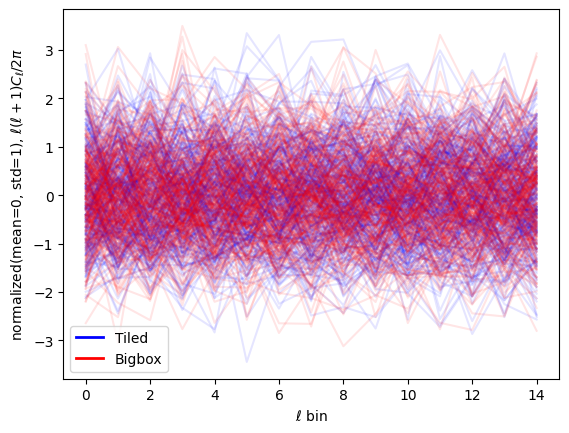

In [ ]:
plt.plot(cl_tiled_norm.T, color="blue", alpha=0.1)
plt.plot(cl_bigbox_norm.T, color="red", alpha=0.1)

plt.legend([Line2D([0], [0], color="blue", lw=2), Line2D([0], [0], color="red", lw=2)], ["Tiled", "Bigbox"])

plt.xlabel(r"$\ell$"+ " bin")
plt.ylabel("normalized(mean=0, std=1), "r"$\ell(\ell+1)C_\ell/2\pi$")
plt.show()

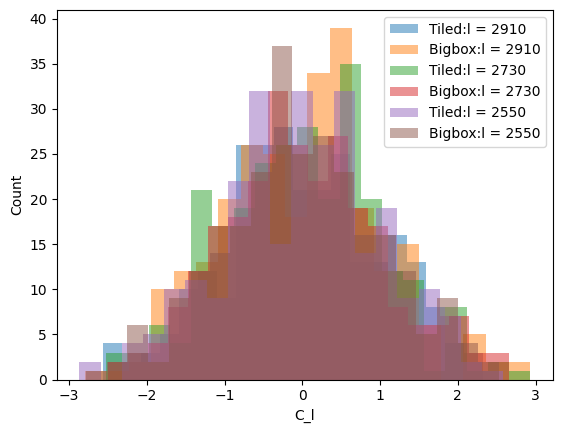

In [ ]:
for i in range(1, 4):
    plt.hist(cl_tiled_norm[:, -i], bins=20, alpha=0.5, label="Tiled:" + f"l = {ell[-i]:.0f}")
    plt.hist(cl_bigbox_norm[:, -i], bins=20, alpha=0.5, label="Bigbox:" + f"l = {ell[-i]:.0f}")
plt.xlabel("C_l")
plt.ylabel("Count")
plt.legend()
plt.show()

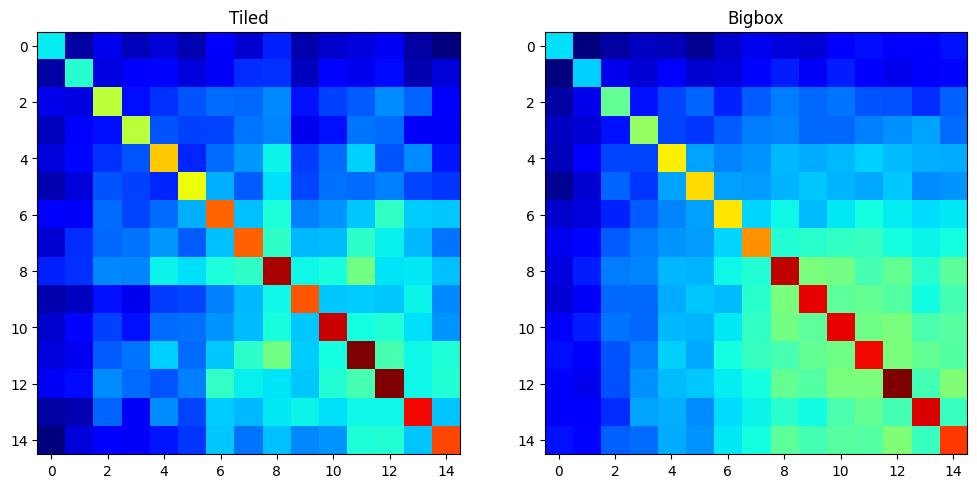

In [ ]:
cov_tiled = np.cov(cl_tiled_reduced.T)
cov_bigbox = np.cov(cl_bigbox_reduced.T)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cov_tiled, cmap="jet")
ax[0].set_title("Tiled")
ax[1].imshow(cov_bigbox, cmap="jet")
ax[1].set_title("Bigbox")

plt.show()

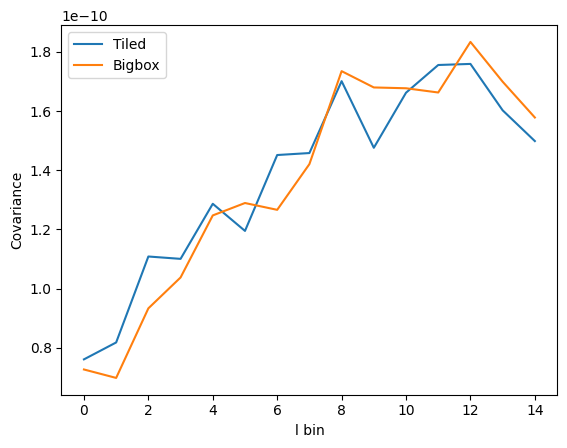

In [ ]:
# diagonal terms of the covariance matrix
plt.plot(np.diag(cov_tiled), label="Tiled")
plt.plot(np.diag(cov_bigbox), label="Bigbox")
plt.legend()
plt.xlabel("l bin")
plt.ylabel("Covariance")
plt.show()


# Full data

In [5]:
def discretize_cl(cl_cont,lmin=300, lmax=3000, nbin=15):
        l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
        ell = np.arange(2, lmax + 1)
        bin_indices = np.digitize(ell, l_edges, right=True)

        # Exclude out-of-range indices
        valid = (bin_indices > 0) & (bin_indices <= nbin)
        bin_indices = bin_indices[valid]
        cl_values = cl_cont # Assuming cl_cont starts at ell=0

        cl_sum = np.bincount(bin_indices, weights=cl_values[valid], minlength=nbin + 1)
        counts = np.bincount(bin_indices, minlength=nbin + 1)

        with np.errstate(divide='ignore', invalid='ignore'):
            cl_disc = np.divide(cl_sum, counts, where=counts > 0)[1:nbin + 1]


        return cl_disc

In [18]:
# Fullsky area in square degrees 
fs_area = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 100 / fs_area
l_area = 2 * np.pi * ell * np.diff(l_edges) + np.pi * np.diff(l_edges) ** 2
nmodes = f_sky * l_area 

# load theoretical data
file_paths = (workdir / "theory" /  "halofit").glob("*.npz")
file_paths = sorted(file_paths)
cl_theory = {}
for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    for file_path in file_paths:
        if f"zs{zs}" in file_path.name:
            data = np.load(file_path)
            clkk = discretize_cl(data["clkk"], lmin=lmin, lmax=lmax, nbin=nbin) * ell * (ell + 1) / (2 * np.pi)
            clkk_cov= clkk**2 / nmodes * 2
            cl_theory[zs] = {"clkk":clkk, "clkk_cov":clkk_cov, "ell":data["ell"]}

In [19]:
#statsfile_bigbox = workdir / "output" / "prev" / "bigbox" / "patch_stats_bigbox_oa10_noiseless_sl2.npy"
#statsfile_tiled = workdir / "output" / "prev" / "tiled" / "patch_stats_tiled_oa10_noiseless_sl2.npy"

statsfile_bigbox = workdir / "output" / "prev" / "bigbox" / "patch_stats_bigbox_oa10_ngal30_sl2.npy"
statsfile_tiled = workdir / "output" / "prev" / "tiled" / "patch_stats_tiled_oa10_ngal30_sl2.npy"

stats_bigbox = np.load(statsfile_bigbox, allow_pickle=True).item()
stats_tiled = np.load(statsfile_tiled, allow_pickle=True).item()

In [20]:
n=3

clkk_bigbox = {}
clkk_tiled = {}

for zs in [0.5, 1.0, 1.5, 2.0, 2.5]:
    clkk_bigbox[zs] = {"means": stats_bigbox[zs]["means"][15*n:15*(n+1)], "stds": stats_bigbox[zs]["stds"][15*n:15*(n+1)], "cov": stats_bigbox[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_bigbox[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_bigbox[zs]["diags"][15*n:15*(n+1)]}
    clkk_tiled[zs] = {"means": stats_tiled[zs]["means"][15*n:15*(n+1)], "stds": stats_tiled[zs]["stds"][15*n:15*(n+1)], "cov": stats_tiled[zs]["cov"][15*n:15*(n+1), 15*n:15*(n+1)], "corr": stats_tiled[zs]["corr"][15*n:15*(n+1), 15*n:15*(n+1)], "diags": stats_tiled[zs]["diags"][15*n:15*(n+1)]}


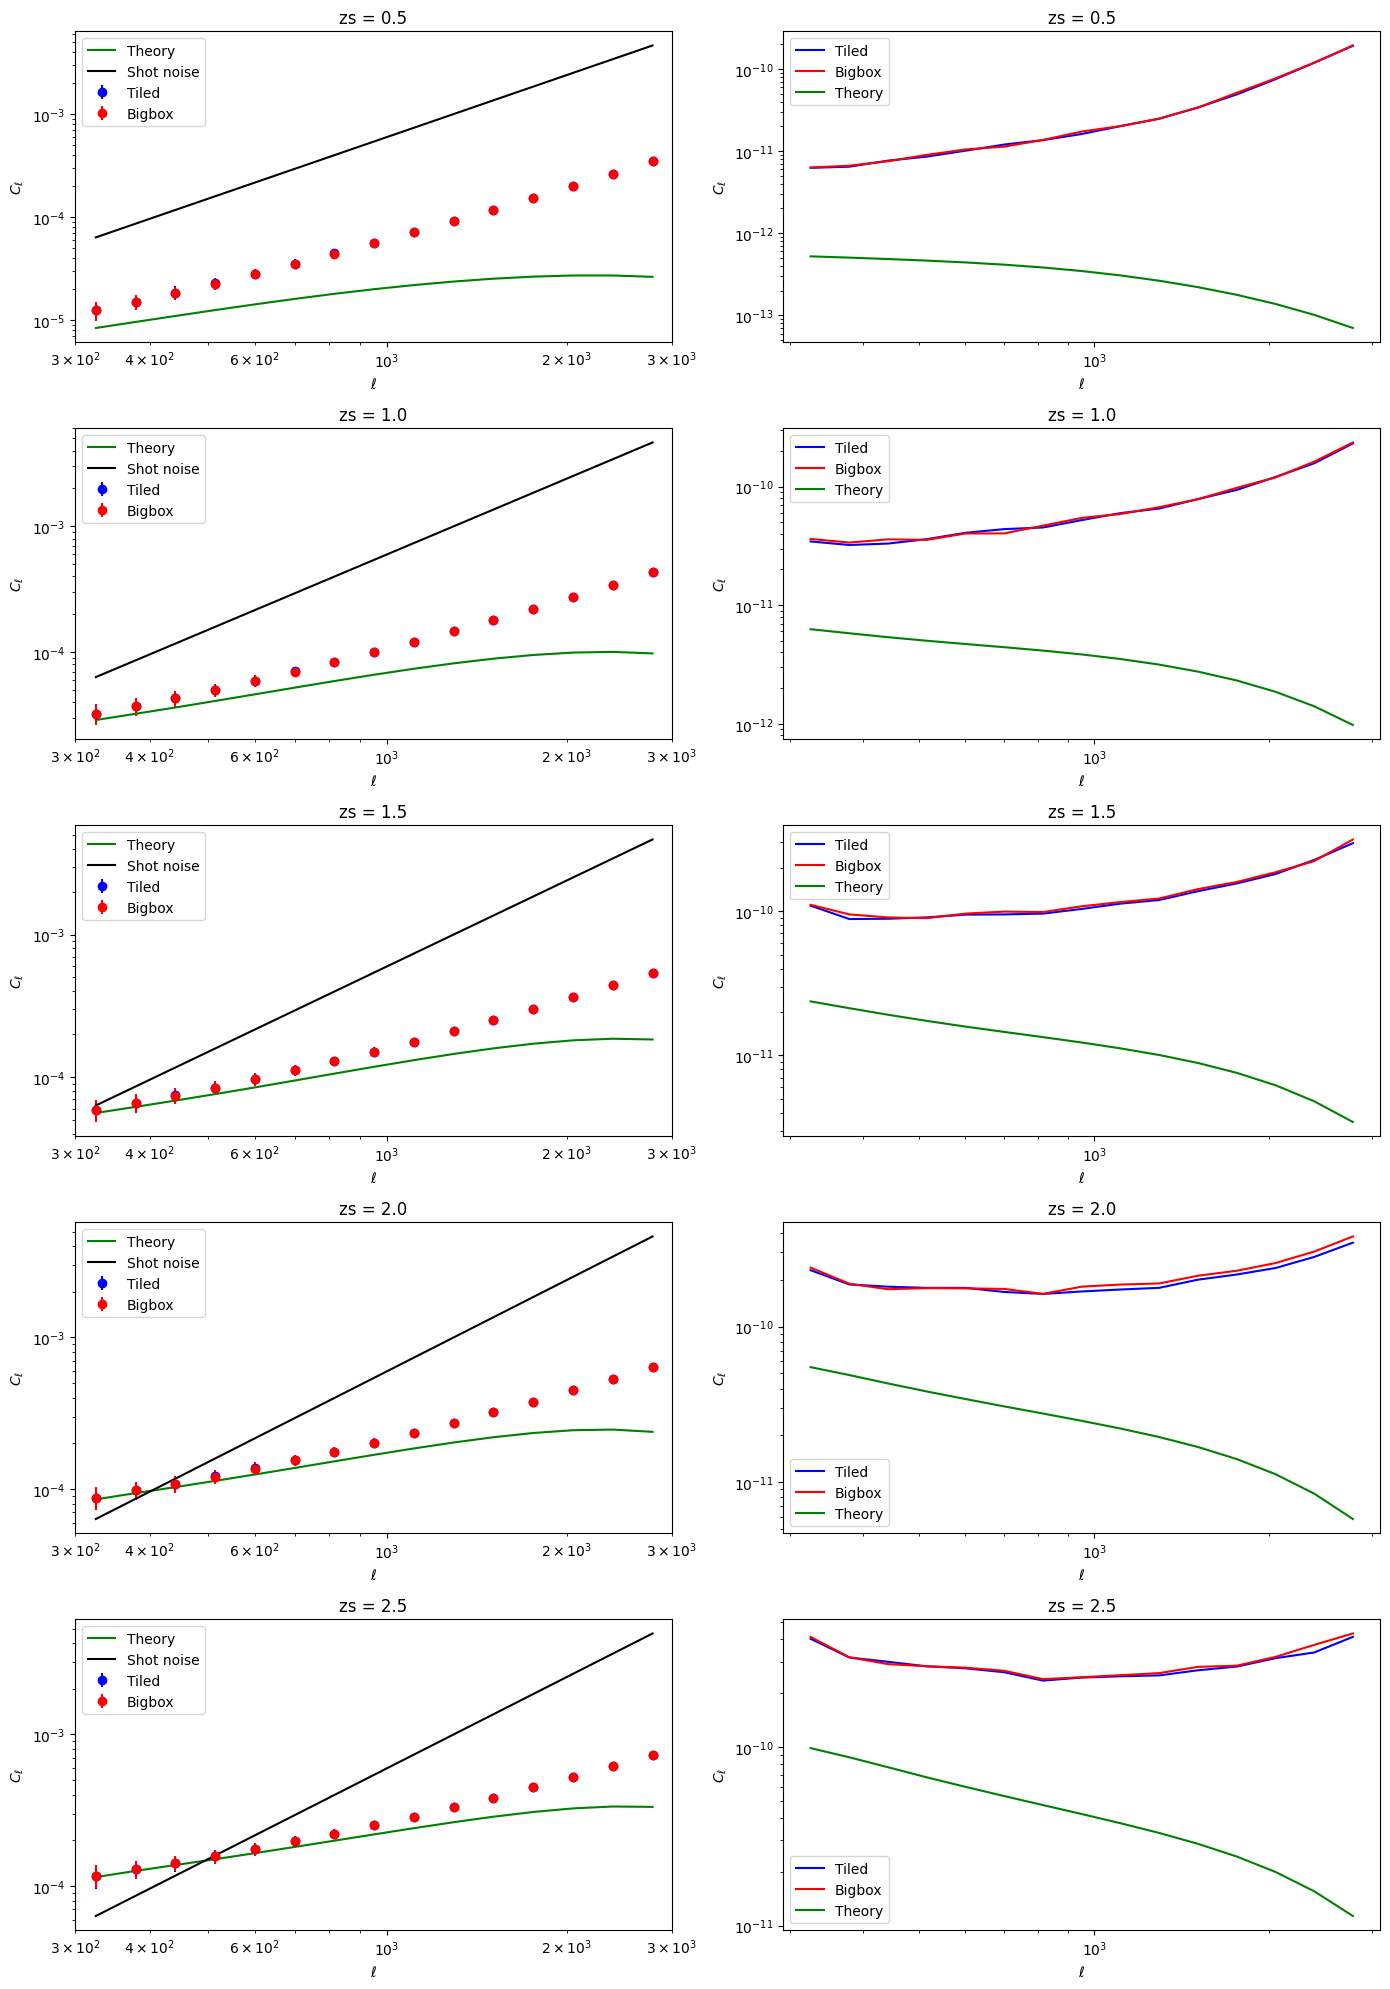

In [24]:
# plot means with errorbars, and theoretical values.
# plot diags

patch_size = 10 # deg
xsize = 2048
pix_size = patch_size / xsize * 60 # arcmin
survey_area =  (patch_size *60 ) ** 2 # deg^2

shot_noise = 0.26**2 / (50 * survey_area)

fig, ax = plt.subplots(5, 2, figsize=(14, 20))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    ax[i, 0].errorbar(ell, clkk_tiled[zs]["means"], yerr=clkk_tiled[zs]["stds"], fmt="o", label="Tiled", color="blue")
    ax[i, 0].errorbar(ell, clkk_bigbox[zs]["means"], yerr=clkk_bigbox[zs]["stds"], fmt="o", label="Bigbox", color="red")
    ax[i, 0].plot(ell, cl_theory[zs]["clkk"], label="Theory", color="green")
    ax[i, 0].plot(ell, shot_noise * ell * (ell + 1) / (2 * np.pi), label="Shot noise", color="black")
    ax[i, 0].set_xlim(300, 3000)
    ax[i, 0].set_title(f"zs = {zs}")
    ax[i, 0].set_xscale("log")
    ax[i, 0].set_yscale("log")
    ax[i, 0].set_xlabel(r"$\ell$")
    ax[i, 0].set_ylabel(r"$C_\ell$")
    ax[i, 0].legend()

    ax[i, 1].plot(ell, clkk_tiled[zs]["diags"], label="Tiled", color="blue")
    ax[i, 1].plot(ell, clkk_bigbox[zs]["diags"], label="Bigbox", color="red")
    ax[i, 1].plot(ell, cl_theory[zs]["clkk_cov"], label="Theory", color="green")
    ax[i, 1].set_title(f"zs = {zs}")
    ax[i, 1].set_xscale("log")
    ax[i, 1].set_yscale("log")
    ax[i, 1].set_xlabel(r"$\ell$")
    ax[i, 1].set_ylabel(r"$C_\ell$")
    ax[i, 1].legend()

plt.tight_layout()
plt.show()


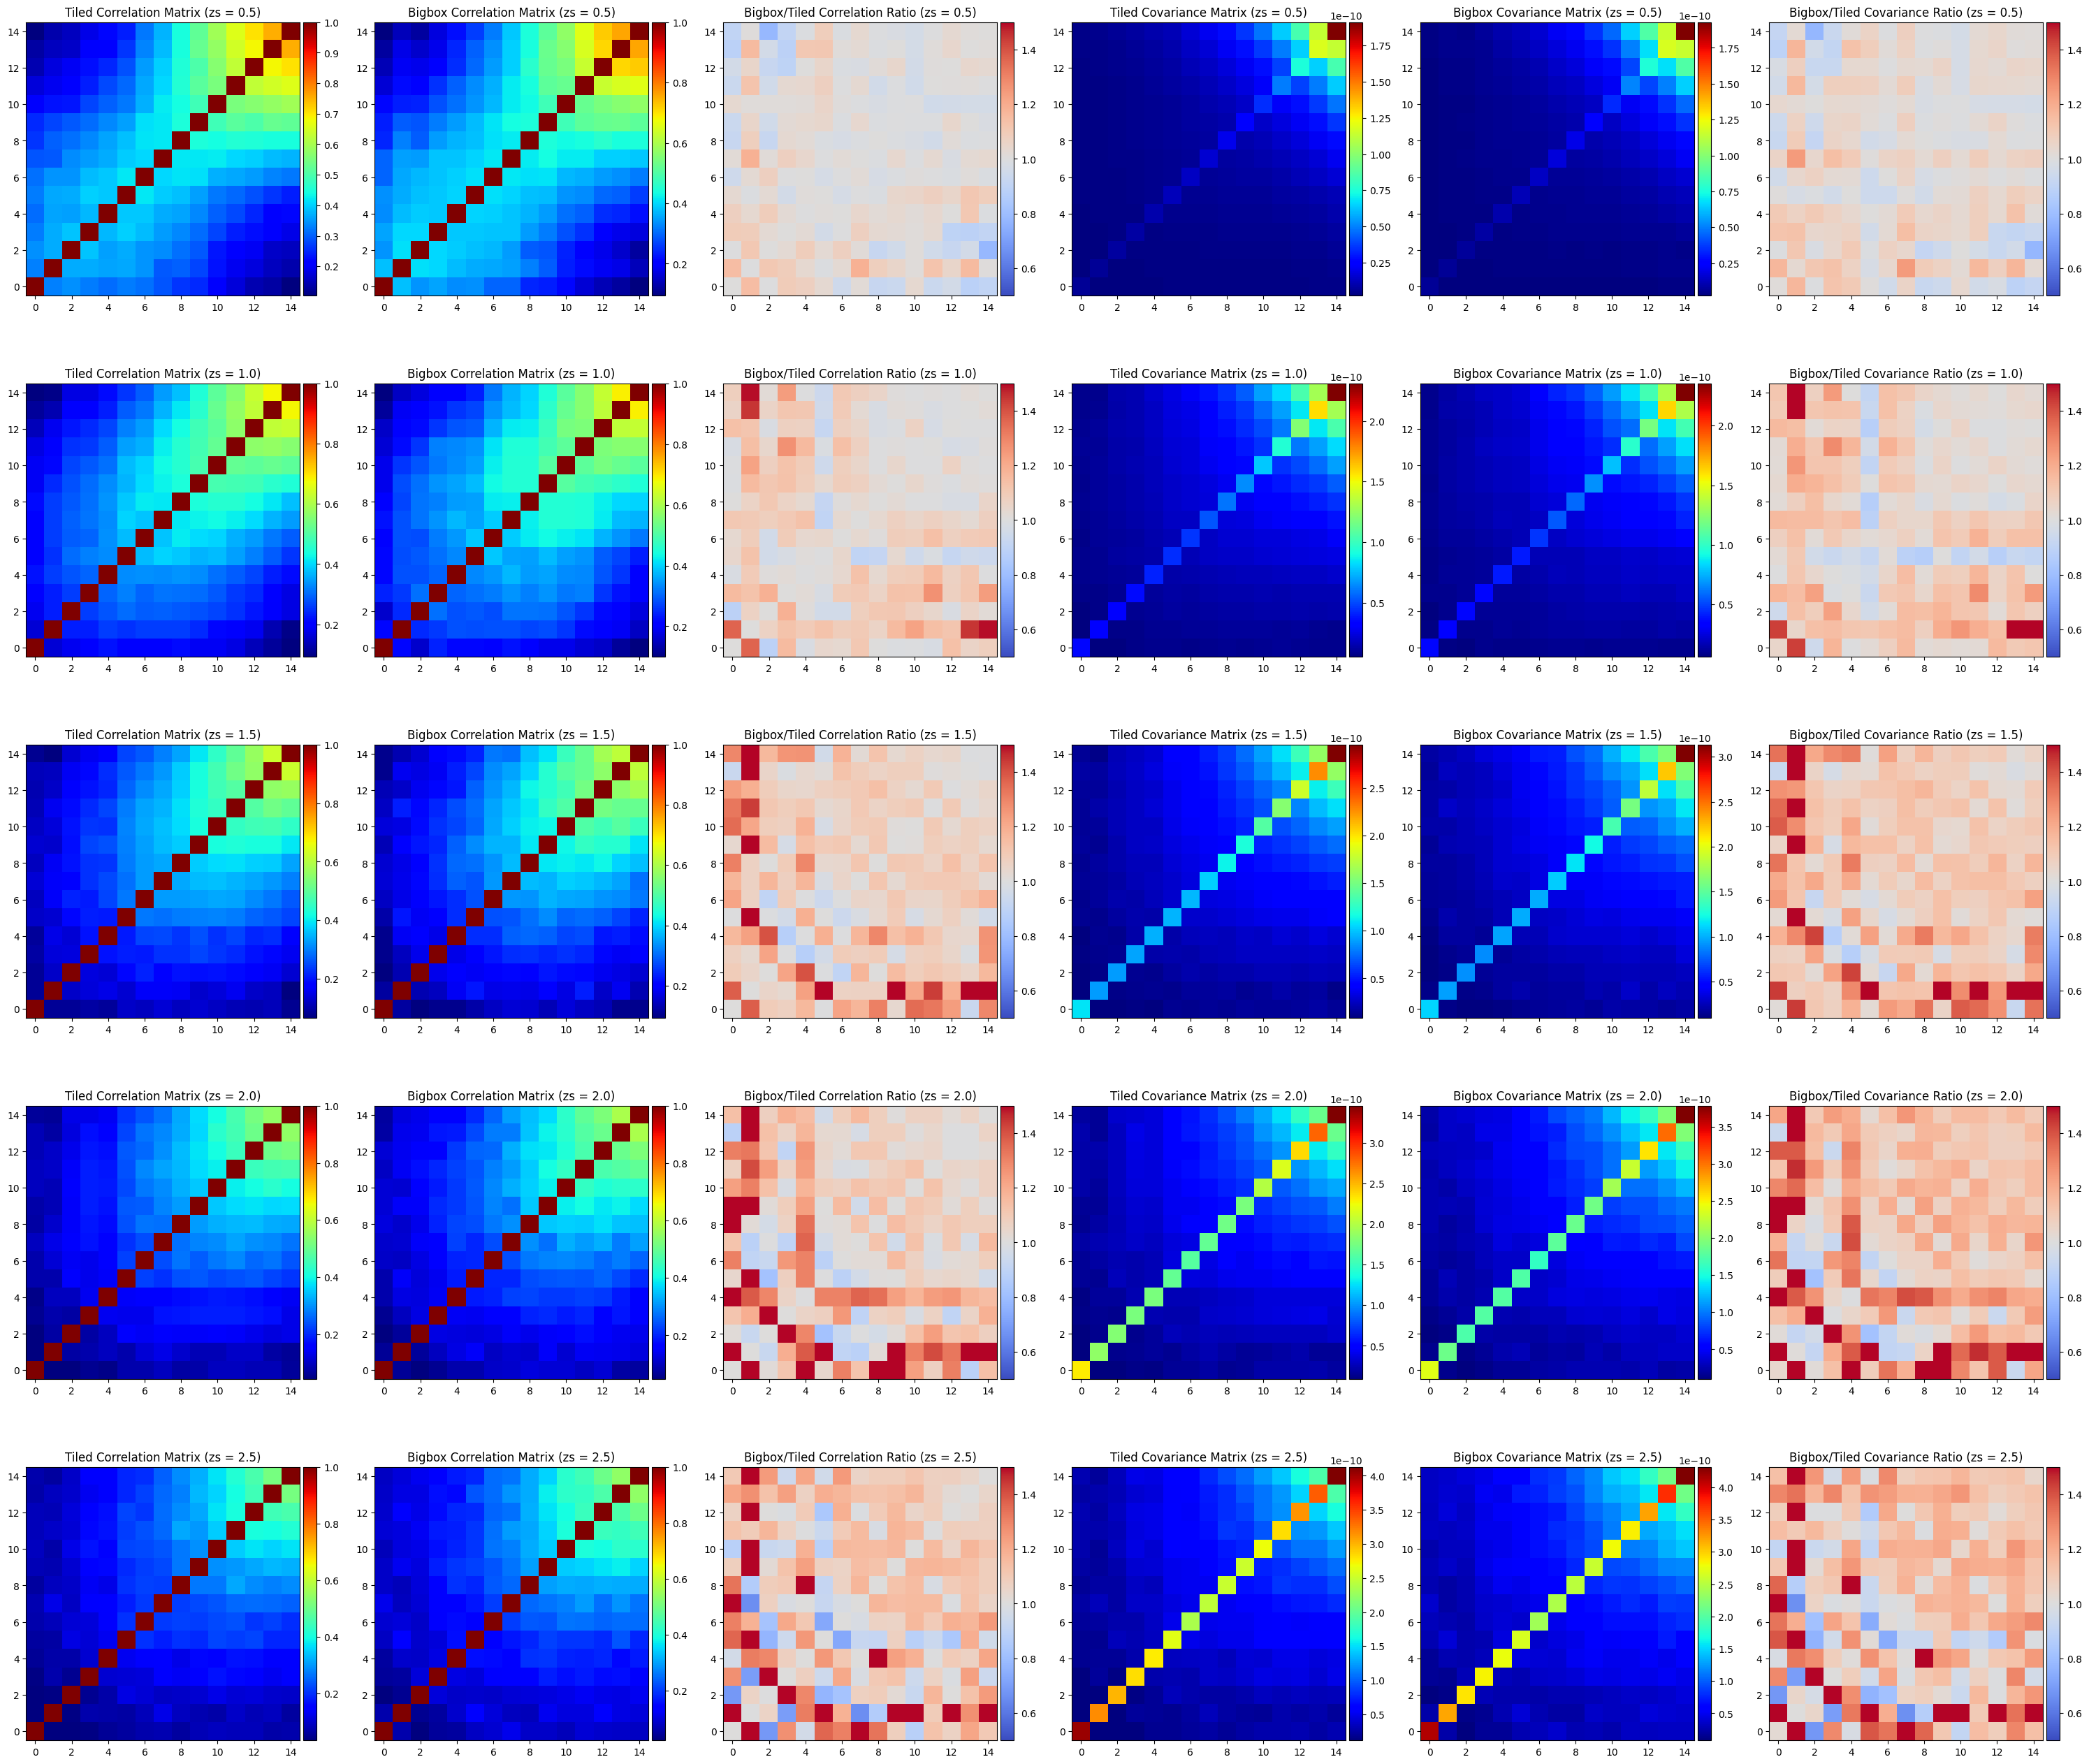

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot correlation matrix and covariance matrix
fig, ax = plt.subplots(5, 6, figsize=(30, 26))
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    im = ax[i, 0].imshow(clkk_tiled[zs]["corr"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 0].set_title(f"Tiled Correlation Matrix (zs = {zs})")

    im = ax[i, 1].imshow(clkk_bigbox[zs]["corr"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 1].set_title(f"Bigbox Correlation Matrix (zs = {zs})")

    im = ax[i, 2].imshow(clkk_bigbox[zs]["corr"]/clkk_tiled[zs]["corr"], cmap="coolwarm", vmin=0.5, vmax=1.5, origin="lower")
    divider = make_axes_locatable(ax[i, 2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 2].set_title(f"Bigbox/Tiled Correlation Ratio (zs = {zs})")

    im = ax[i, 3].imshow(clkk_tiled[zs]["cov"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 3])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 3].set_title(f"Tiled Covariance Matrix (zs = {zs})")

    im = ax[i, 4].imshow(clkk_bigbox[zs]["cov"], cmap="jet", origin="lower")
    divider = make_axes_locatable(ax[i, 4])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 4].set_title(f"Bigbox Covariance Matrix (zs = {zs})")

    im = ax[i, 5].imshow(clkk_bigbox[zs]["cov"]/clkk_tiled[zs]["cov"], cmap="coolwarm", vmin=0.5, vmax=1.5, origin="lower")
    divider = make_axes_locatable(ax[i, 5])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i, 5].set_title(f"Bigbox/Tiled Covariance Ratio (zs = {zs})")

plt.tight_layout()
plt.show()

In [26]:
import h5py

def load_results_from_hdf5(hdf5_path):
    """
    Loads the results from an HDF5 file into a nested dictionary.
    
    Parameters:
    - hdf5_path (str or Path): Path to the HDF5 file.
    
    Returns:
    - results (dict): Nested dictionary mirroring the original structure.
    """
    results = {}
    with h5py.File(hdf5_path, 'r') as hf:
        for ngal_key in hf.keys():
            # Extract 'ngal' value from group name
            ngal = int(ngal_key.replace('ngal_', ''))
            results[ngal] = {}
            ngal_group = hf[ngal_key]
            
            # Load 'cl', 'equilateral', 'isosceles', 'squeezed'
            for key in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                if key in ngal_group:
                    results[ngal][key] = np.array(ngal_group[key])
            
            # Iterate over 'sl' groups
            for sl_key in ngal_group.keys():
                if sl_key.startswith('sl_'):
                    sl = int(sl_key.replace('sl_', ''))
                    results[ngal][sl] = {}
                    sl_group = ngal_group[sl_key]
                    
                    for sub_key in ['pdf', 'peaks', 'minima', 'v0', 'v1', 'v2', 'sigma0', 'sigma1']:
                        if sub_key in sl_group:
                            results[ngal][sl][sub_key] = np.array(sl_group[sub_key])
    return results

In [27]:
tiled_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("tiled/stats/*.h5"))
bigbox_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("bigbox/stats/*.h5"))

In [28]:
clkk_tiled = {}
for tiled_dir in tiled_dirs:
    results = load_results_from_hdf5(tiled_dir)
    # find "_zs{zs}_" in the file name
    zs = float(tiled_dir.name.split("_")[1].replace("zs", ""))
    if zs not in clkk_tiled:
        clkk_tiled[zs] = []
    clkk_tiled[zs].append(results[0]["cl"])

In [29]:
for zs in clkk_tiled:
    clkk_tiled[zs] = np.array(np.concatenate(clkk_tiled[zs]))

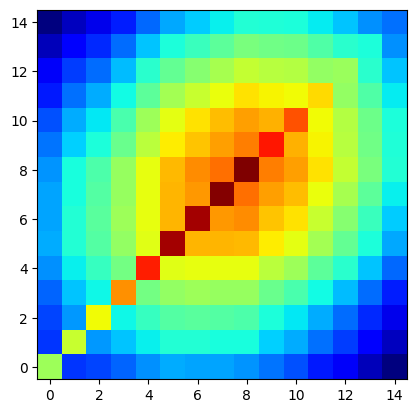

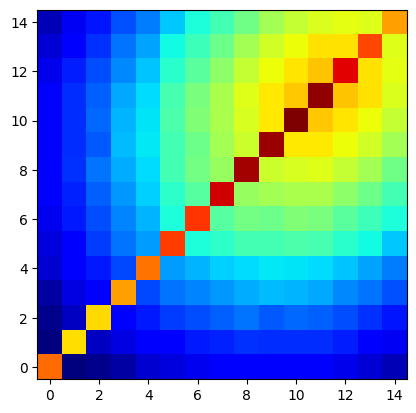

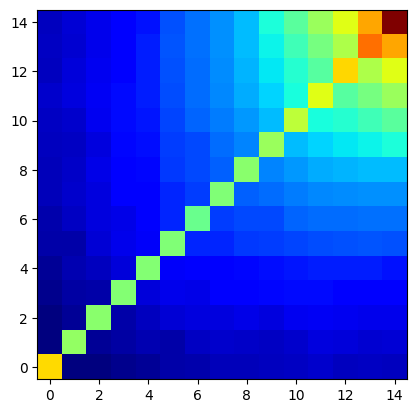

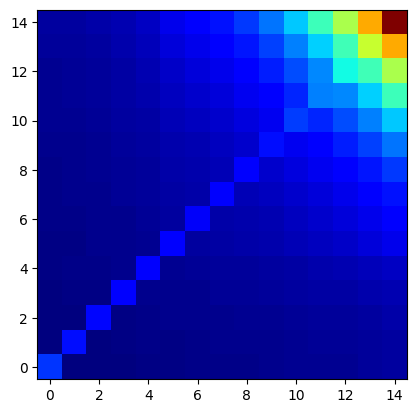

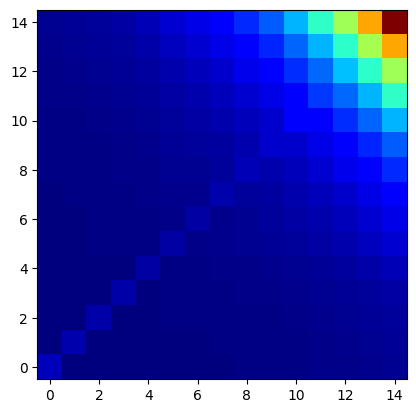

In [36]:
plt.imshow(np.cov(clkk_tiled[0.5].T), cmap="jet", origin="lower")
plt.show()

plt.imshow(np.cov(clkk_tiled[1.0].T), cmap="jet", origin="lower")
plt.show()

plt.imshow(np.cov(clkk_tiled[1.5].T), cmap="jet", origin="lower")
plt.show()

plt.imshow(np.cov(clkk_tiled[2.0].T), cmap="jet", origin="lower")
plt.show()

plt.imshow(np.cov(clkk_tiled[2.5].T), cmap="jet", origin="lower")
plt.show()

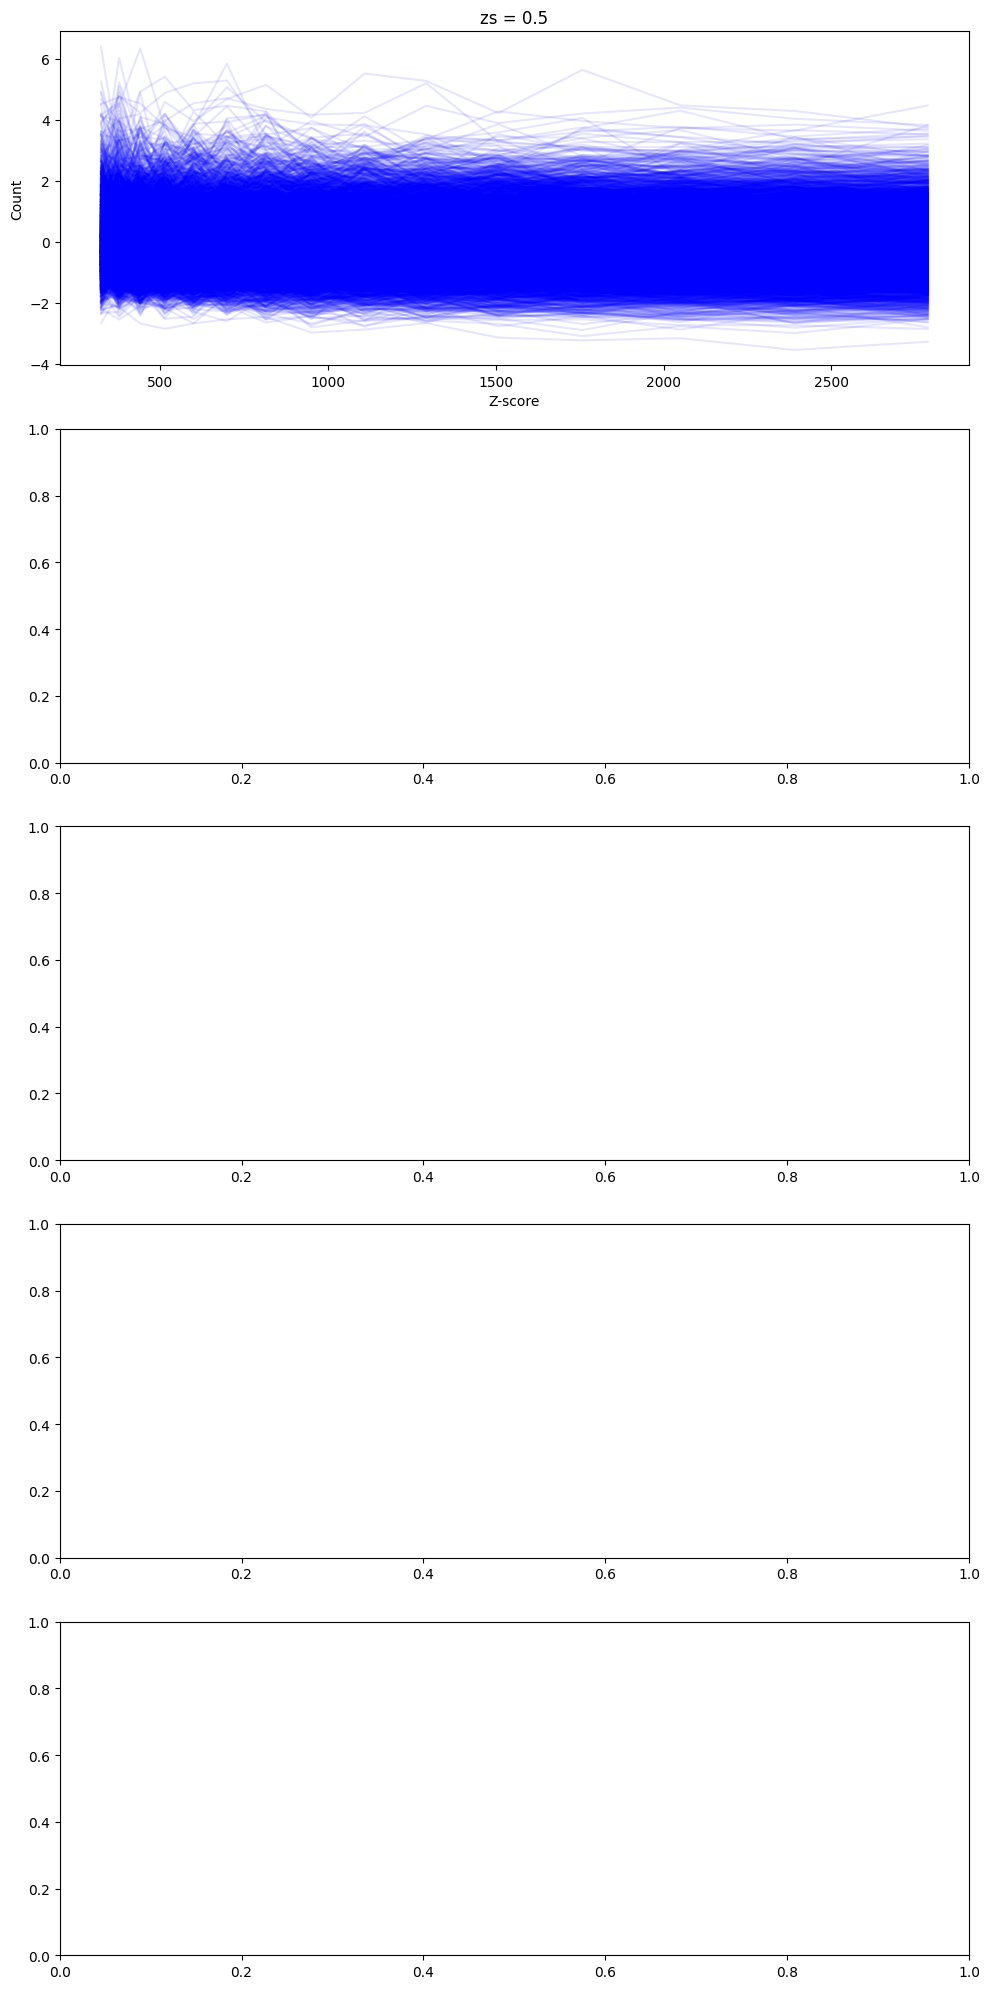

In [34]:
# plot z-score distribution for each zs
fig, ax = plt.subplots(5, 1, figsize=(10, 20))
for i, zs in enumerate([0.5]):
    tmp_zscore = (clkk_tiled[zs] - np.nanmean(clkk_tiled[zs], axis=0)) / np.nanstd(clkk_tiled[zs], axis=0)

    for j in range(tmp_zscore.shape[0]):
        ax[i].plot(ell, tmp_zscore[j, :], label=f"zs = {zs}", color="blue", alpha=0.1)
    ax[i].set_title(f"zs = {zs}")
    ax[i].set_xlabel("Z-score")
    ax[i].set_ylabel("Count")
plt.tight_layout()
plt.show()